### 함수로 만들어준다.

드렁가는 라이브러리 | 들어가는 함수 | 설명
----------|----------|----------
math|math.log10()|
numpy|set_printoptions(),set_option()|
pandas|DataFrame(),groupby(),join,.read_csv()|
numpy.linalg|norm()|
IPython.display||

나오는 변수 | 들어가는 변수 | 설명
----------|----------|----------
movies| | 무비 파일을 가져온다.
movieGenres|movies|movies에서 index= movieId와 columne=genres만 가져온다.
totalItems|movies| movies의 전체 index 갯수를 세준다.
genres|movieGenres,totalItems| (1)genres['moviecount']  (2) genres['idf']
movieGenreWeights |movieGenres,genres |둘을 join해준다.
movieWeights|(1)movies (2)movieGenreWeights| (1)의 movieID와 (2)의 genres,idf를 가져오는것이다.
movieNorms|(1)movieWeights|(1)의 idf들을 Norm시키는 과정이다.
norms|(1)movieNorms|(1)에서 norm값들을 가져온다.
normalizedMovieWeights|(1)movieWeights,   (2)norms|(1)의 idf 에 (2)의 Norm을 나눠 nomalize화 하는것이다.
sims|(1)normalizedMovieWeights  (2)movieWeights| (1)과 (1)의 Transform을 곱해 Cosine similarity를 구해준다.
ratings|| 평점의 csv파일을 가져온다.
train|(1)ratings|정확도 테스트를 위해 random하게 정해진 train 들을 가져온다.(csv에 train과 test가 반영되어있다 이미)
test|(1)ratings|정확도 테스트를 위해 random하게 정해진 test 들을 가져온다.


In [57]:
import math
import numpy as np
import pandas as pd
from IPython.display import Image, display
from numpy import linalg as LA

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)


movies = pd.read_csv('../src/movies_w_imgurl.csv')

movieGenres = pd.DataFrame(
    data=movies['genres']
    .str
    .split('|')   
    .apply(pd.Series)
    .stack()
    ,columns=['genre'])
movieGenres.index = movieGenres.index.droplevel(1)

totalItems = movies.shape[0]
genres = pd.DataFrame(data = movieGenres.groupby('genre')['genre'].count())
genres.columns= ['movieCount']
genres['idf'] = genres['movieCount'].apply(lambda x: math.log10(totalItems/x))


movieGenreWeights = movieGenres.join(genres['idf'], on='genre')

movieWeights = movies[['movieId']]

for genre in genres.index:
    movieWeights = movieWeights\
    .join(movieGenreWeights[movieGenreWeights['genre'] == genre]
    [['idf']].rename(columns={'idf':genre})) 
    movieWeights.fillna(0, inplace=True)
    
movieNorms = pd.DataFrame(
    data=LA.norm(movieWeights
                 .iloc[:,1:] 
                 .values, 
                ord=2, axis=1),

    columns=['norm2'])    

normalizedMovieWeights = pd.DataFrame(index=movieWeights.index) #빈 데이타 프레임만들기
norms = movieNorms['norm2']
for genre in genres.index:
    normalizedMovieWeights[genre] = movieWeights[genre].divide(norms)
    
sims = pd.DataFrame(data=np.matmul(normalizedMovieWeights, normalizedMovieWeights.T), index=movieWeights['movieId'])
sims.columns = index=movieWeights['movieId']

ratings = pd.read_csv('../src/ratings-9_1.csv')
train = ratings[ratings['type'] == 'train'][['userId', 'movieId', 'rating']]
test = ratings[ratings['type'] == 'test'][['userId', 'movieId', 'rating']]




In [50]:

def users(userId):
    ratings = pd.read_csv('../src/ratings-9_1.csv')
    train = ratings[ratings['type'] == 'train'][['userId', 'movieId', 'rating']]
    test = ratings[ratings['type'] == 'test'][['userId', 'movieId', 'rating']]
    
    sumDataframe=[]
    
    #for i in userId:
    #    userId = i
    userRatings = train[train['userId'] == userId][['movieId', 'rating']]

    recSimSums = sims.loc[userRatings['movieId'].values, :].sum().values
    recWeightedRatingSums = np.matmul(sims.loc[userRatings['movieId'].values, :].T.values, userRatings['rating'].values)
    recItemRatings = pd.DataFrame(data=np.divide(recWeightedRatingSums, recSimSums), index=sims.index)
    recItemRatings.columns = ['prediction']   
    #userRatings = train[train['userId'] == userId][['movieId', 'rating']]
    #topRatings = userRatings.sort_values(by='rating', ascending=False).head(5)

    #return recItemRatings
    predictionAvg = recItemRatings['prediction'].sum()/len(recItemRatings['prediction'])

    recItemRatings['prediction']/=predictionAvg

    highRatings=5
    return recItemRatings*highRatings/2





In [51]:
user_number_list=[99,13,14,111,33,345,55,66,44,7]
#movied_number=


In [52]:
def multiRec(user_number_list):
    multi=0
    for i in user_number_list:
        multi += users(i)
    multi/=len(user_number_list)
    multi=multi.sort_values(by='prediction', ascending=False)
    return multi


In [53]:
def want_test(user_number,movied_number):


    print ("유저",user_number,"의 영화",movied_number,"의 평점은 =", users(user_number)['prediction'][movied_number] )

    count=0
    k=users(user_number).sort_values(by='prediction',ascending=False)['prediction'][movied_number]
    for i in users(user_number).sort_values(by='prediction',ascending=False)['prediction']:
        if i >=k:
                count+=1

    print("전체",9125,"중에" , count, "등")

In [54]:
def check(user_number_list,num):
    for j in user_number_list:
        want_test(j,num) # User 99 => 400등,  13=> 30등,  14= 1500등

In [55]:
multiRec=multiRec(user_number_list)
multiRec

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


,prediction
movieId,
8700,2.72
5611,2.72
4445,2.72
55442,2.72
107559,2.72
61236,2.72
392,2.72
27611,2.72
42351,2.72


In [56]:
check(user_number_list,8700)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


유저 99 의 영화 8700 의 평점은 = 2.54013280379
전체 9125 중에 4264 등
유저 13 의 영화 8700 의 평점은 = 2.88592034434
전체 9125 중에 199 등
유저 14 의 영화 8700 의 평점은 = 3.15460035335
전체 9125 중에 457 등
유저 111 의 영화 8700 의 평점은 = 2.47507543287
전체 9125 중에 5339 등
유저 33 의 영화 8700 의 평점은 = 2.17423857099
전체 9125 중에 8882 등
유저 345 의 영화 8700 의 평점은 = 2.64929789352
전체 9125 중에 545 등
유저 55 의 영화 8700 의 평점은 = 2.66875871745
전체 9125 중에 5168 등
유저 66 의 영화 8700 의 평점은 = 2.9127297095
전체 9125 중에 215 등
유저 44 의 영화 8700 의 평점은 = 3.05357661862
전체 9125 중에 250 등
유저 7 의 영화 8700 의 평점은 = 2.73499743629
전체 9125 중에 2242 등


In [39]:
def displayMovies(movieIds,ratings=[]):
    i = 0
    for movieId in movieIds:
        mov = movies[movies['movieId'] == movieId].iloc[0]
        display(Image(mov.imgurl))
        print(mov.title)
        print(mov.genres)
        if i < len(ratings):
            print("hi")
            print(ratings[i])
        i +=1

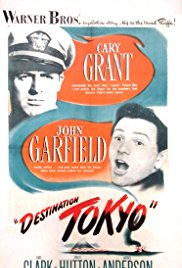

Destination Tokyo (1943)
Adventure|War


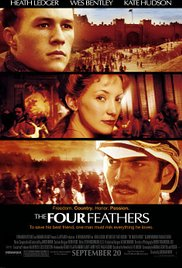

Four Feathers, The (2002)
Adventure|War


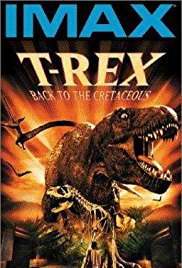

T-Rex: Back to the Cretaceous (1998)
Adventure|Documentary|IMAX


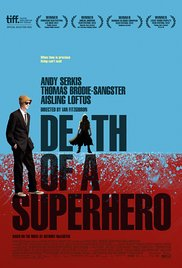

Am Ende eiens viel zu kurzen Tages (Death of a superhero) (2011)
Animation|Drama


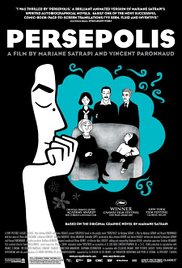

Persepolis (2007)
Animation|Drama


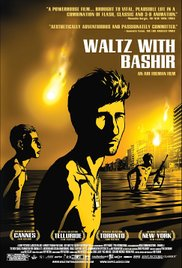

Waltz with Bashir (Vals im Bashir) (2008)
Animation|Documentary|Drama|War


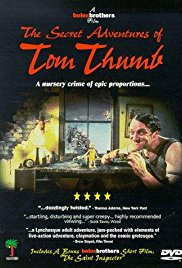

Secret Adventures of Tom Thumb, The (1993)
Adventure|Animation


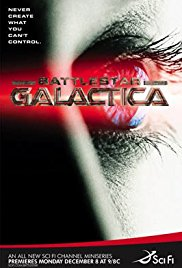

Battlestar Galactica (2003)
Drama|Sci-Fi|War


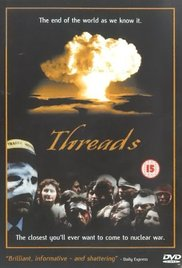

Threads (1984)
Drama|Sci-Fi|War


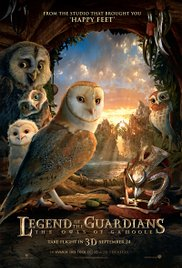

Legend of the Guardians: The Owls of Ga'Hoole (2010)
Adventure|Animation|Fantasy|IMAX


In [41]:
displayMovies(multiRec.sort_values(by='prediction', ascending=False).head(10).index)

### 정확도를 분석해본다.

In [38]:
userTestRatings = pd.DataFrame(data=test[test['userId'] == userId])
temp = userTestRatings.join(recItemRatings.loc[userTestRatings['movieId']], on='movieId')
mae = (temp['rating'] - temp['prediction']).abs().mean()
rmse = math.sqrt((temp['rating'] - temp['prediction']).pow(2).mean())
print(" MAE:", mae)
print("RMSE:", rmse)

(' MAE:', 0.8688257414607422)
('RMSE:', 0.980180039768629)
